In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import datetime

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib

# metrics
from sklearn.metrics import r2_score

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils, ml_utils

# TO DO
- ~~pipeline~~
- ~~full parameter sweep~~
- ~~other models? NN?~~
- ~~feature importance visualisation~~
- ~~Does CCA disappear on grouping?~~ – no, just shifts everything else up
- ~~Test NN – pytorch?~~
- ~~fitting for depth~~
- ~~get uncertainty from RF?~~
- ~~fix plotting shading~~
- ~~visualise by site/depth~~
- ~~better simulation~~
- ~~add synthetic as train data source~~
- ~~emulate S2 from validation spectra~~
- ~~apply ML to wider image(s)~~
- ~~Weibull fit spectra for depth~~ - now binormal
- ~~statistical significance of depth on fit? ANOVA! (just to piss Eric off)~~
- ~~repeated row chunks in validation?~~ – duplication over multiple potential pixels
- visualise variance on feature: look into calculation of rolling importance
- check difference between validation v1 and v2
- rank fits by combination of individual fits and depth derivation r2s
- try with simulation only

In [2]:
# load labels (recorded benthic cover)
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_data.head()

X         Y Campaign         Locale  Station      TimeUTC  \
0  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
1  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
2  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
3  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   
4  145.463908 -14.69196      GBR  Lizard Island      523  9/4/16 0:38   

      TimeLocal  Depth Metabolism Optics  ... othInvert  othOther  othSponge  \
0  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
1  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
2  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
3  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   
4  9/4/16 10:38    1.6        NaN    NaN  ...         0         0          0   

   othUrchin  sedLimest  sedMud  sedRubble  sedSand  ROInumber  \
0          0          0       0          0       27          1   
1          0          0       0          0       27          1   
2          0          0       0          0       27          1   
3          0          0       0          0       27          1   
4          0          0       0          0       27          1   

                         Flightline  
0  prm20160908t225710_corr_v1w2_img  
1  prm20160908t225710_corr_v1w2_img  
2  prm20160908t225710_corr_v1w2_img  
3  prm20160908t225710_corr_v1w2_img  
4  prm20160908t225710_corr_v1w2_img  

[5 rows x 34 columns]

In [3]:
(X_train, X_test), (y_train, y_test), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits").generate_data()
print("N train samples:", X_train.shape[0])
print("N features:", X_train.shape[1])
print("N test samples:", X_test.shape[0])
print("Label dimensions:", y_train.shape[1])

N train samples: 3100
N features: 84
N test samples: 388
Label dimensions: 1


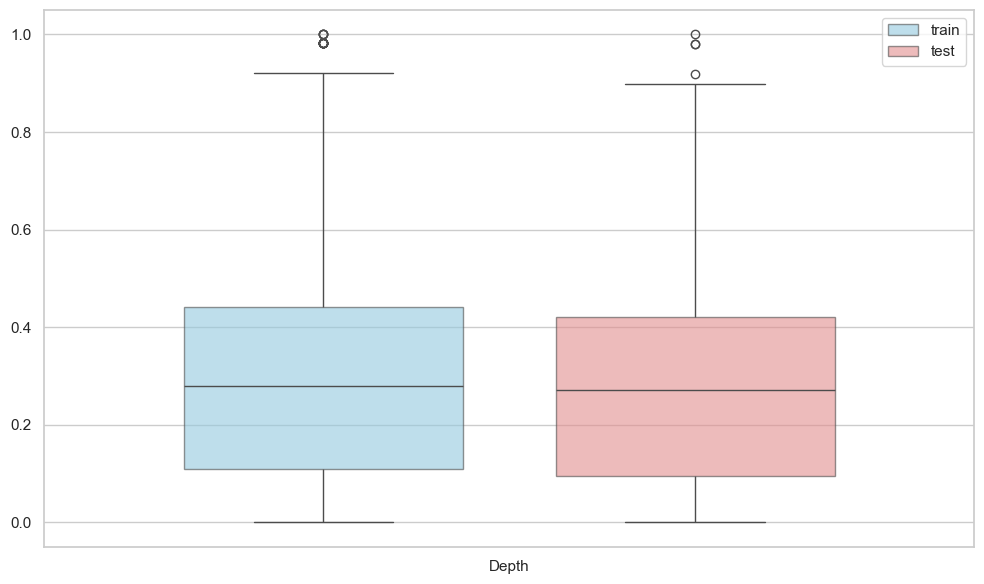

In [4]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=y_train, ax=ax, positions=np.arange(len(y_train.columns)) - 0.2, width=0.3, color="skyblue", boxprops=dict(alpha=0.6), label="train")
sns.boxplot(data=y_test, ax=ax, positions=np.arange(len(y_test.columns)) + 0.2, width=0.3, color="lightcoral", boxprops=dict(alpha=0.6), label="test")

plt.legend()
plt.tight_layout()

In [5]:
validation_data["Locale"] == "Kaneohe Bay"

0       False
1       False
2       False
3       False
4       False
        ...  
1933    False
1934    False
1935    False
1936    False
1937    False
Name: Locale, Length: 1938, dtype: bool

In [6]:
# exclude KBay from training
kbay_inds = validation_data[validation_data["Locale"] == "Kaneohe Bay"].index
# drop rows intersecting with kbay_inds from X_train
X_train = X_train.drop(kbay_inds.intersection(X_train.index))
y_train = y_train.drop(kbay_inds.intersection(y_train.index))
X_train.shape

(2460, 84)

In [61]:
save_models = True
# best_rf = ml_utils.sklModels(model_type="random_forest", n_iter_search=100).return_fitted_model(X_train, y_train)
# best_gbr = ml_utils.sklModels(model_type="gradient_boosting", n_iter_search=1000).return_fitted_model(X_train, y_train)
# best_mlp = ml_utils.sklModels(model_type="mlp", n_iter_search=500).return_fitted_model(X_train, y_train)

if save_models:
    # make directory
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    current_models_dir = file_ops.get_dir(file_ops.MODELS_DIR_FP / timestamp)

    # joblib.dump(best_gbr, current_models_dir / "best_gbr.pkl")
    joblib.dump(best_rf, current_models_dir / "best_rf_depth_100.pkl")
    # joblib.dump(best_mlp, current_models_dir / "best_mlp_no_kaneohe.pkl")

In [15]:
# predict
# fitted_rf = best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R^2 for RandomForest: {r2_rf:.3f}")

# y_pred_gbr = best_gbr.predict(X_test)
# r2_gbr = r2_score(y_test, y_pred_gbr)
# print(f"R^2 for MultiOutputGradientBoosted: {r2_gbr:.3f}")

# y_pred_mlp = best_mlp.predict(X_test)
# r2_mlp = r2_score(y_test, y_pred_mlp)
# print(f"R^2 for MLP: {r2_mlp:.3f}")

R^2 for RandomForest: 0.723


In [16]:
def get_model_std_dev(model, y_test: pd.DataFrame) -> pd.DataFrame:

    predictions = []
    for i, tree in enumerate(model.estimators_):
        predictions.append(tree.predict(X_test))
        
    np.array(predictions).shape
    stds = np.std(predictions, axis=0)
    
    return stds
            
def generate_model_metadata(validation_data, model, y_test):
    std_dev_predictions = get_model_std_dev(model, y_test)
    predictions_std_dev = pd.DataFrame(std_dev_predictions, index=y_test.index, columns=[col + "_std_dev" for col in y_test.columns])
    return pd.concat([validation_data.loc[y_test.index, ["Locale", "Depth"]], predictions_std_dev], axis=1)

    
test_data = y_test
pred_data = y_pred_rf

metadata = generate_model_metadata(validation_data, best_rf, y_test)
# metadata = validation_data.loc[y_test.index, ["Locale", "Depth"]]


In [17]:
# # Combine test_data and pred_data in a multiindex dataframe
# data_multiindex = pd.MultiIndex.from_product([["true", "pred"], labels.columns], names=["source", "label"])
# combined_data = np.hstack([test_data, pred_data])
# data_df = pd.DataFrame(combined_data, index=y_test.index, columns=data_multiindex)

# # Concatenate data_df and metadata_df
# results_df = pd.concat([data_df, metadata_df], axis=1)
# results_df

In [12]:
test_data = y_test
pred_data = y_pred_mlp

# plotting.plot_regression_results(test_data, pred_data, labels, metadata=metadata, color_by="Depth")

In [54]:
y_test_depth

algae     coral  sand
582    0.28  0.289157  0.48
901    0.53  0.566265  0.00
907    0.57  0.506024  0.01
1754   0.53  0.554217  0.00
1464   0.83  0.096386  0.09
...     ...       ...   ...
1914   0.59  0.457831  0.03
1639   0.71  0.000000  0.29
1263   0.78  0.265060  0.00
530    0.15  0.506024  0.43
192    0.92  0.024096  0.05

[388 rows x 3 columns]

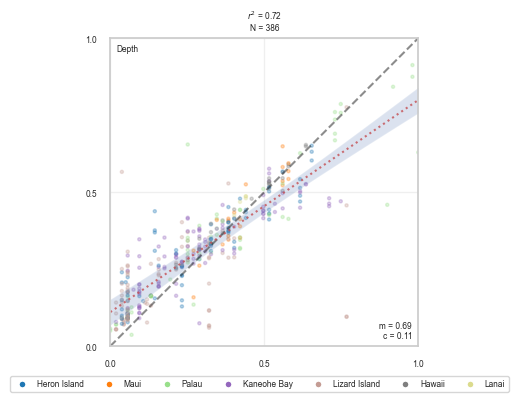

In [60]:
# scale depth data

(X_train, _), (_, y_test_depth), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits").generate_data()

test_data = y_test_depth
pred_data = y_pred_rf

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plotting.plot_regression_axis(fig, axes, test_data, pred_data, labels, 
                              metadata=metadata,
                              color_by="Locale")

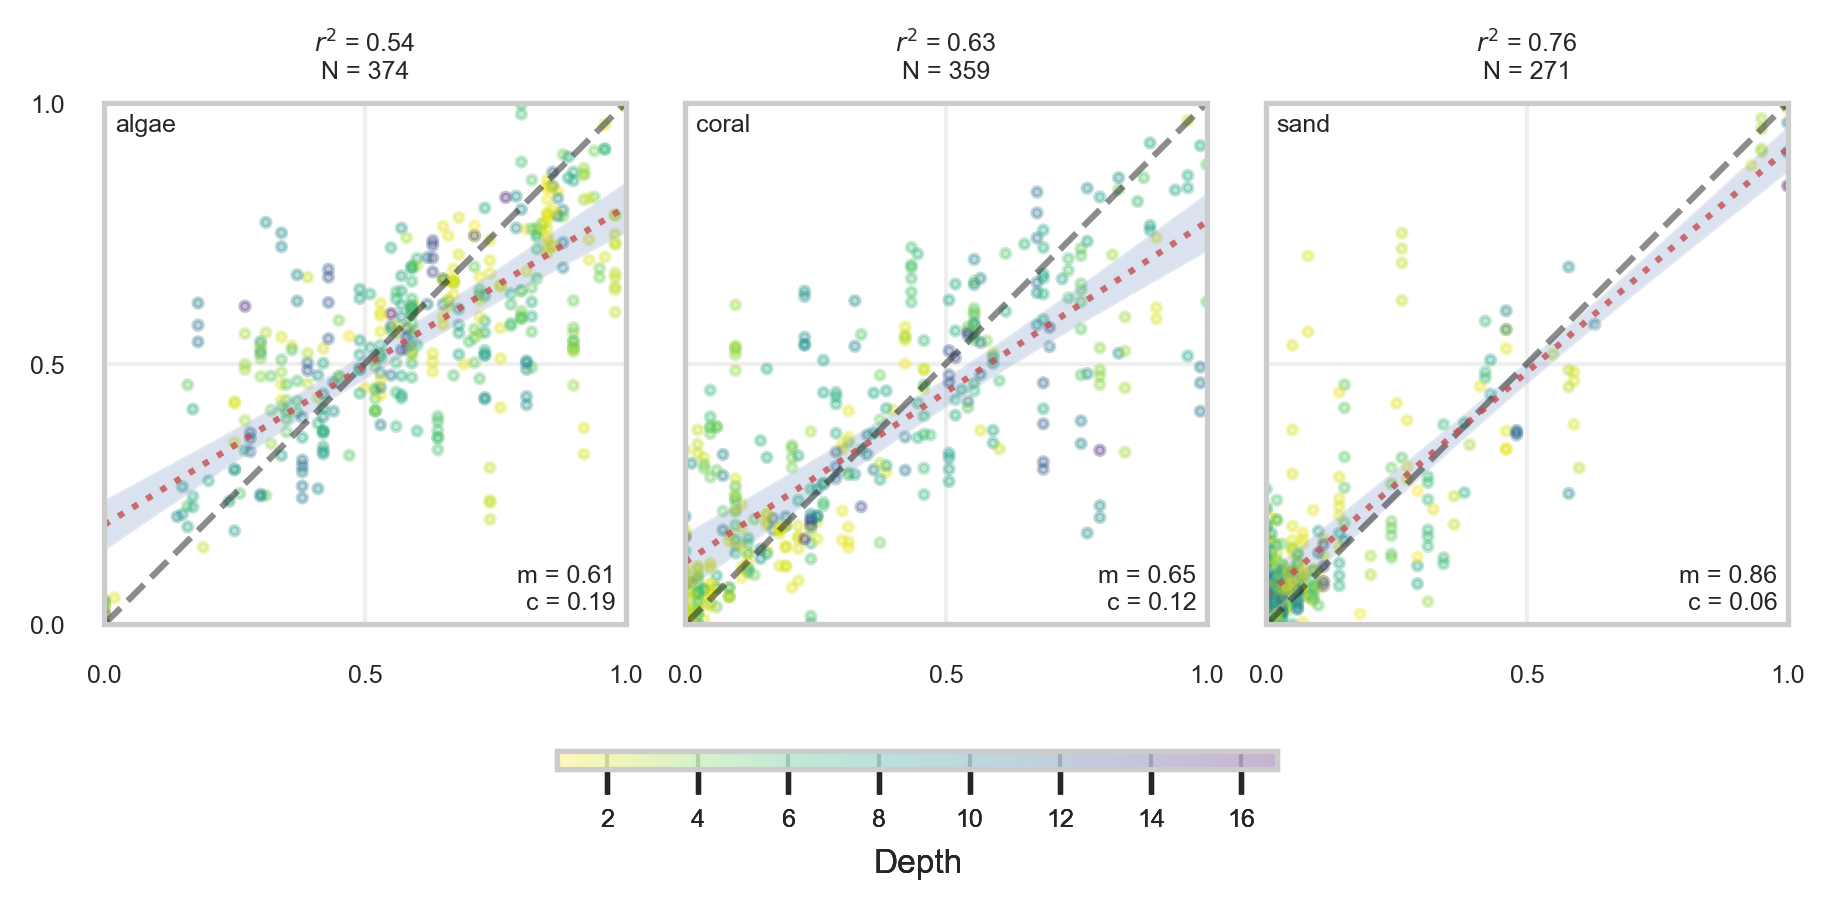

In [44]:
(X_train, _), (_, y_test_benthic), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()

test_data = y_test_benthic
# /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/resources/models/20241003-164331/best_benthic_mlp_no_kaneohe.pkl
pred_data = np.clip(joblib.load(file_ops.MODELS_DIR_FP / "20241003-164331/best_benthic_mlp_no_kaneohe.pkl").predict(X_test), 0, 1)

plotting.plot_regression_results(test_data, pred_data, test_data,
                                 metadata=metadata,
                                 color_by="Depth")

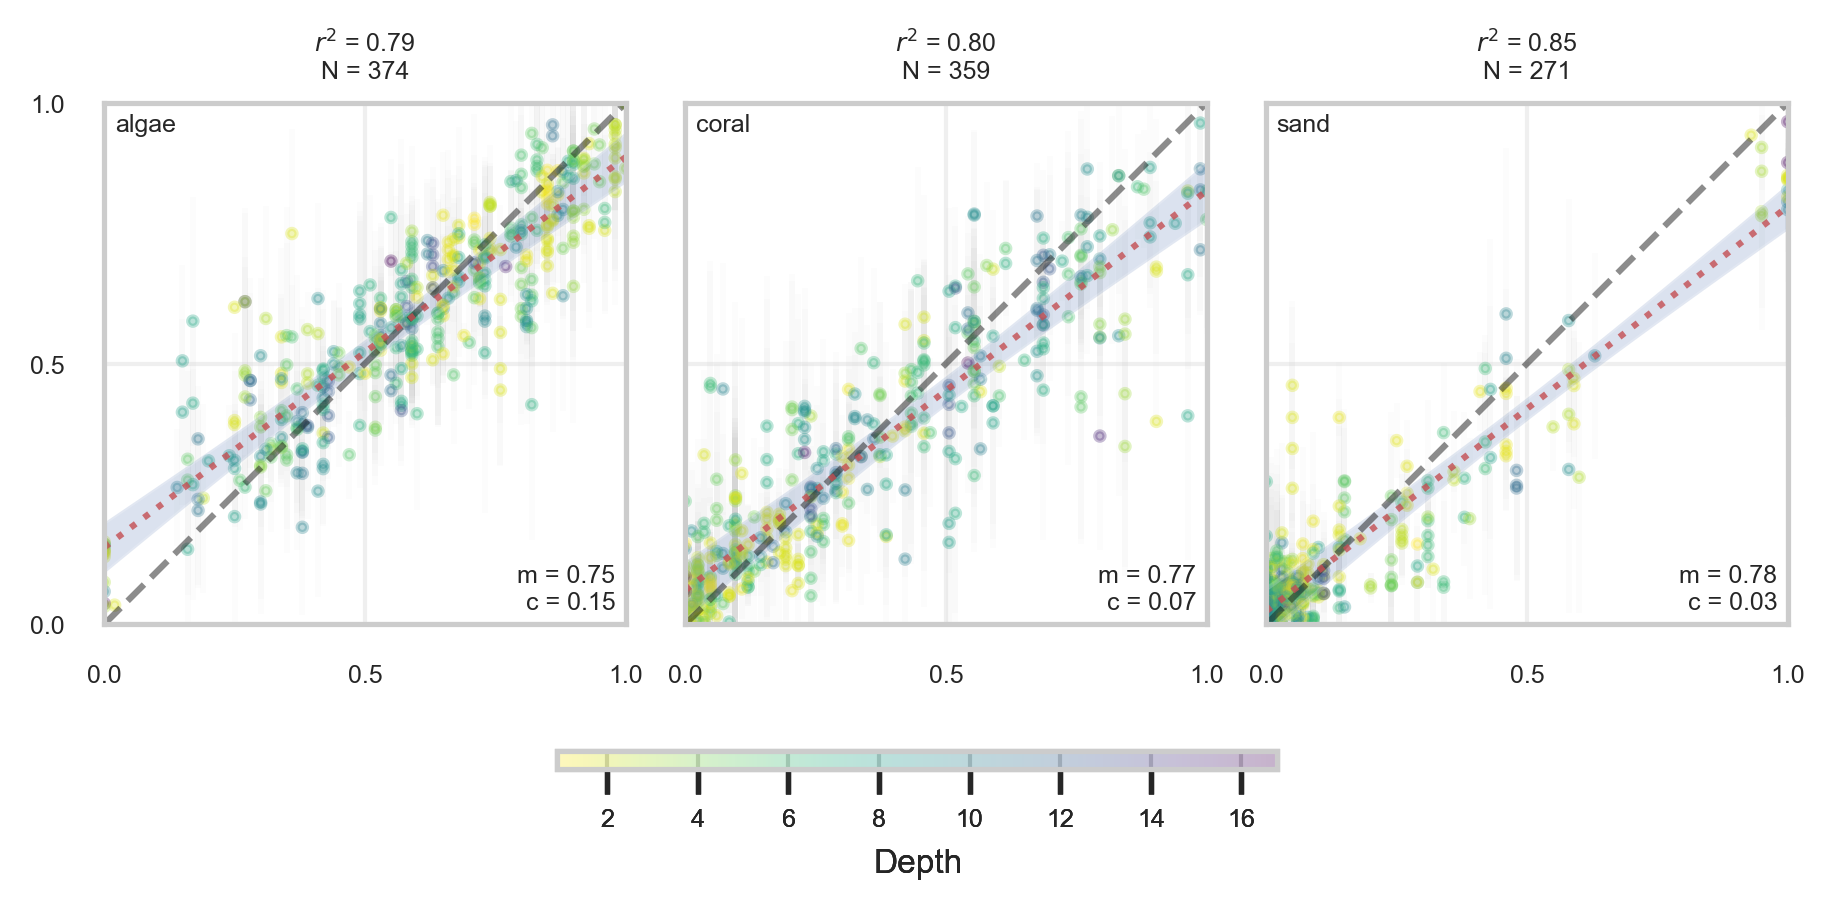

In [78]:
test_data = y_test
pred_data = y_pred_mlp

plotting.plot_regression_results(test_data, pred_data, labels,
                                 metadata=metadata, 
                                 color_by="Depth")

In [94]:
errors_df = test_data - pred_data
# errors_df["Depth"] = metadata["Depth"]


In [98]:
from scipy.stats import pearsonr, spearmanr

# for each label, run a statistical test to see dependence on depth
correlation_results = {}

# Loop through each target and compute the correlation with depth
for target in errors_df.columns:
    # Pearson correlation
    pearson_corr, pearson_p = pearsonr(metadata["Depth"], errors_df[target])
    
    # Spearman correlation (alternative to Pearson if you prefer a rank-based test)
    spearman_corr, spearman_p = spearmanr(metadata["Depth"], errors_df[target])
    
    # Store the results in a dictionary
    correlation_results[target] = {
        'Pearson Correlation': pearson_corr,
        'Pearson p-value': pearson_p,
        'Spearman Correlation': spearman_corr,
        'Spearman p-value': spearman_p
    }

correlation_df = pd.DataFrame(correlation_results).T
correlation_df


Pearson Correlation  Pearson p-value  Spearman Correlation  \
algae            -0.127788         0.011757             -0.122643   
coral             0.049309         0.332679              0.105318   
sand              0.117922         0.020157              0.082346   
Depth             1.000000         0.000000              1.000000   

       Spearman p-value  
algae          0.015644  
coral          0.038117  
sand           0.105331  
Depth          0.000000

In [193]:
# test the statistical significance on depth on the accuracy of the model
import statsmodels.api as sm

# calculate error for each class
error = test_data - pred_data
error_df = pd.DataFrame(error, columns=labels.columns)
error_df["Depth"] = metadata["Depth"]
error_df = error_df.melt(id_vars="Depth", var_name="label", value_name="error")
error_df['intercept'] = 1

error_df

Depth  label     error  intercept
0      11.3  algae -0.268383          1
1      10.1  algae -0.072241          1
2       7.6  algae  0.130832          1
3       6.1  algae  0.072937          1
4       5.8  algae  0.038203          1
...     ...    ...       ...        ...
1159    2.0   sand -0.037806          1
1160    0.9   sand  0.162448          1
1161    5.5   sand -0.071375          1
1162    7.9   sand -0.021844          1
1163    3.4   sand -0.022008          1

[1164 rows x 4 columns]

In [195]:
# Fit the regression model
model = sm.OLS(error_df['error'], error_df[['intercept', 'Depth']]).fit()
print(model.summary())

# ANOVA
from statsmodels.formula.api import ols
model = ols("error ~ Depth", data=error_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03058
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.861
Time:                        15:18:04   Log-Likelihood:                 636.75
No. Observations:                1164   AIC:                            -1270.
Df Residuals:                    1162   BIC:                            -1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.008     -0.274      0.7

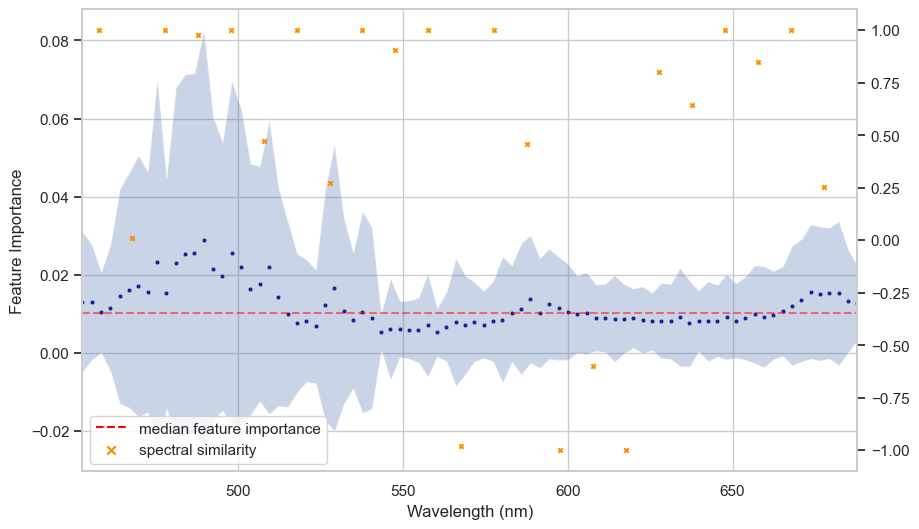

In [526]:
# plot a scatterplot of mean importance, with std shaded
rf_importances = np.array([tree.feature_importances_ for tree in best_rf.estimators_])
importance_df = pd.DataFrame(rf_importances, columns=X_train.columns).agg(["mean", "std"]).T

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=importance_df.index, y=importance_df["mean"], s=10, ax=ax, color="darkblue")
ax.fill_between(importance_df.index, importance_df["mean"] - importance_df["std"], importance_df["mean"] + importance_df["std"], alpha=0.3)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Feature Importance")
ax.set_xlim(min(importance_df.index), max(importance_df.index))
ax.hlines(np.median(importance_df["mean"]), min(importance_df.index), max(importance_df.index), linestyle="--", alpha=0.5, color="red")

kernel_width = 10
kernel_displacement = 10
ax_metric = ax.twinx()
wv_pairs, (mean_corrs, std_corrs) = spectrum_utils.calc_rolling_similarity(X_train.columns, X_test.values[:2,:], kernel_width, kernel_displacement, spectrum_utils.calc_spectral_similarity_gradient)
ax_metric.scatter([np.mean(pair) for pair in wv_pairs], mean_corrs, s=10, c="darkorange", marker="x", zorder=-100)
ax_metric.grid(False)

ax_metric.plot([],[],linestyle="--", color="red", label="median feature importance")
ax_metric.scatter([],[], color="darkorange", label="spectral similarity", marker="x")

ax_metric.legend()

# Simulation only

In [14]:
g_cfg, run_cfg = file_ops.instantiate_single_configs_instance(run_ind = 0)

sims = optimisation_pipeline.SimulateSpectra(run_cfg, g_cfg).generate_simulated_spectra()

import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add traces for each spectrum
for i in range(sims.shape[0]):
    fig.add_trace(go.Scatter(
        x=sims.columns[4:],  # Wavelengths
        y=sims.iloc[i, 4:],  # Spectra values
        mode='lines',
        line=dict(color='black', width=1),
        opacity=0.05,
        hoverinfo='text',
        text=f"Depth: {sims.iloc[i]['depth']:.2f}, K: {sims.iloc[i]['K']:.2f}, bb: {sims.iloc[i]['bb']:.2f}"
    ))

# Update layout
fig.update_layout(
    title="Simulated Spectra",
    xaxis_title="Wavelength (nm)",
    yaxis_title="Reflectance",
    showlegend=False,
    width=1400,
    height=600,
    # yaxis=dict(range=[0, max(validation_spectra.T.max())]),
)

# Show the figure
fig.show()

Generating simulated spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def simulate_Rbs()